In [1]:
import csv
import thesis_tools
from thesis_tools.utilities import get_f_star, calc_f
import numpy as np
import pandas as pd

from scipy.stats import linregress
from itertools import chain

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize

import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
red=sb.xkcd_palette(['pale red'])[0]


% matplotlib inline
plt.style.use('sm')

In [2]:
sheffer_data=pd.read_csv('sheffer_co_h2.csv')
burgh_data=pd.read_csv('burgh_data.csv')
published_hs=pd.read_csv('clean_vizier_results.csv')

# Gets elemental depletion parameters from Jenkins09 Table 4
epcols=['Ax','Bx','zx']
element_params=pd.read_csv('jenkins_table4.csv')
element_params[epcols]=element_params[epcols].apply(pd.to_numeric)
element_params['El']=pd.Series([x.strip() for x in element_params['El']])

In [3]:
with open('primary_sightlines.csv','r') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=next(inp)

sl_data=thesis_tools.load_data(primary_sightlines)
all_data=thesis_tools.load_results(sl_data)

/Users/codydirks/python/thesis_tools/loaders.py:105: RuntimeWarning: divide by zero encountered in log10
  n_dict[ion]=round(np.log10(n_tot),3)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarni

In [2]:
import numpy as np
import pickle as pkl
# This cell extracts the curves from the plots of Gong et al. (2017)
# for abundances of species as a function of N(Htot)

from skimage import io, img_as_float, color,exposure
from scipy import stats
files=[50,100,200,500,700,1000]

# Colours of interest
# Each tuple is a color to be isolated in the Gong plots,
# with the form (color_id, CIE color, RGB color identifier)
cols = [('C',np.array([54.29,80.81,69.89]),'r'),
        ('CO',np.array([45.90,71.61,-46.57]),'m'),
        ('C+',np.array([74.95,-11.19,68.45]),'y')
       ]

co_c_cii_theor_results=[]
for fl in files:
    img=io.imread('{:}.png'.format(fl))

    img = img_as_float(img[:,:,0:3])

    # Put image into LAB colour space
    image_lab = color.rgb2lab(img)
    img = exposure.rescale_intensity(img)    
    # Loop through the color array and pick out the colored features
    # Compute distance between the color of interest and the actual image
    # http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.deltaE_cmc
    # "The usual values are kL=2, kC=1 for “acceptability”"
    num_y_pix,num_x_pix=img.shape[0:2]


    fit_results=[]
    for species,cie_col,rgb_col in cols:
        distance_color = color.deltaE_ciede2000(cie_col, image_lab, kL=2, kC=1, kH=0.5)    

        # Normalise distance
        distance_color = exposure.rescale_intensity(distance_color)

        # Mask image
        image_filtered = img.copy()
        image_filtered[distance_color > 0.1] = 1
        y,x=np.where(image_filtered[:,:,0] != 1)
        y=(-9./num_y_pix)*y+19.
        x=(2./num_x_pix)*x+20.

        #f, (ax0,ax1)=plt.subplots(1,2)
        #f.set_figwidth(12)
        # Plot it up
        #ax0.imshow(img,aspect='auto',extent=[20,22,10,19])
        #ax1.imshow(distance_color, cmap='gray')
        #ax1.imshow(image_filtered,aspect='auto',extent=[20,22,10,19])
        #ax1.scatter(x,y,marker='o',color=rgb_col,s=.1)
        #ax1.set_ylim(10,19)
        
        points=list(zip(x,y))
        fitx=np.empty(0)
        fity=np.empty(0)
        for val in np.arange(20.2,22,0.1):
            ys=[round(i[1],1) for i in points if round(i[0],1)==round(val,1)]
            mod=stats.mode(ys)[0][0]
            fitx=np.concatenate([fitx,[round(val,1)]])
            fity=np.concatenate([fity,[mod]])
            #ax1.plot(val,mod,'ko',markersize=10)
        cheb=np.polynomial.chebyshev.chebfit(fitx,fity,7)
        cheby=np.polynomial.chebyshev.chebval(fitx,cheb)
        finex=np.arange(20.2,22,0.01)
        finey=np.interp(finex,fitx,cheby)
        fit_results.append((species,(finex,finey)))
        #ax1.plot(fitx,cheby,'k-',linewidth=1)
    co_c_cii_theor_results.append((fl,fit_results))

# Colours of interest
# Each tuple is a color to be isolated in the Gong plots,
# with the form (color_id, CIE color, RGB color identifier)
cols = [('H2',np.array([0,0,0]),'k'),]
h2_theor_results=[]
for fl in [str(i)+'_h2' for i in files]:
    img=io.imread('{:}.png'.format(fl))

    img = img_as_float(img[:,:,0:3])

    # Put image into LAB colour space
    image_lab = color.rgb2lab(img)
    img = exposure.rescale_intensity(img)    
    # Loop through the color array and pick out the colored features
    # Compute distance between the color of interest and the actual image
    # http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.deltaE_cmc
    # "The usual values are kL=2, kC=1 for “acceptability”"
    num_y_pix,num_x_pix=img.shape[0:2]


    fit_results=[]
    for species,cie_col,rgb_col in cols:
        distance_color = color.deltaE_ciede2000(cie_col, image_lab, kL=2, kC=1, kH=0.5)    

        # Normalise distance
        distance_color = exposure.rescale_intensity(distance_color)

        # Mask image
        image_filtered = img.copy()
        image_filtered[distance_color > 0.1] = 1
        y,x=np.where(image_filtered[:,:,0] != 1)
        y=(-4./num_y_pix)*y+19.+2.6989
        x=(2./num_x_pix)*x+20.

        #f=plt.figure(figsize=(16,12),facecolor='w')
        #ax0=plt.subplot(121)
        #ax1=plt.subplot(122)
        # Plot it up
        #ax0.imshow(img,aspect='auto',extent=[20,22,15,19])
        #ax1.imshow(distance_color, cmap='gray')
        #ax1.imshow(image_filtered,aspect='auto',extent=[20,22,15,19])
        #ax1.scatter(x,y,marker='o',color=rgb_col,s=.1)
        #ax1.set_ylim(15,19)
        #ax1.set_xlim(20,22)
        points=list(zip(x,y))
        fitx=np.empty(0)
        fity=np.empty(0)
        for val in np.arange(20.2,22,0.1):
            ys=[round(i[1],1) for i in points if round(i[0],1)==round(val,1)]
            mod=stats.mode(ys)[0][0]
            fitx=np.concatenate([fitx,[round(val,1)]])
            fity=np.concatenate([fity,[mod]])
            #ax1.plot(val,mod,'ko',markersize=10)
        cheb=np.polynomial.chebyshev.chebfit(x,y,7)
        cheby=np.polynomial.chebyshev.chebval(fitx,cheb)
        finex=np.arange(20.2,22,0.01)
        finey=np.interp(finex,fitx,cheby)
        fit_results.append((species,(finex,finey)))
        #ax1.plot(fitx,cheby,'k-',linewidth=1)
    h2_theor_results.append((int(fl.split('_')[0]),fit_results))
theor_results=[]
for entry in list(zip(co_c_cii_theor_results,h2_theor_results)):
    n=entry[0][0]
    c,co,cii=entry[0][1]
    h2=entry[1][1][0]
    theor_results.append((n,(c,co,cii,h2)))
with open('gong_results.pkl','wb') as fl:
    pkl.dump(theor_results,fl)

/Users/codydirks/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:127: RankWarning: The fit may be poorly conditioned


Text(5e+15,1e+12,'Integrated')

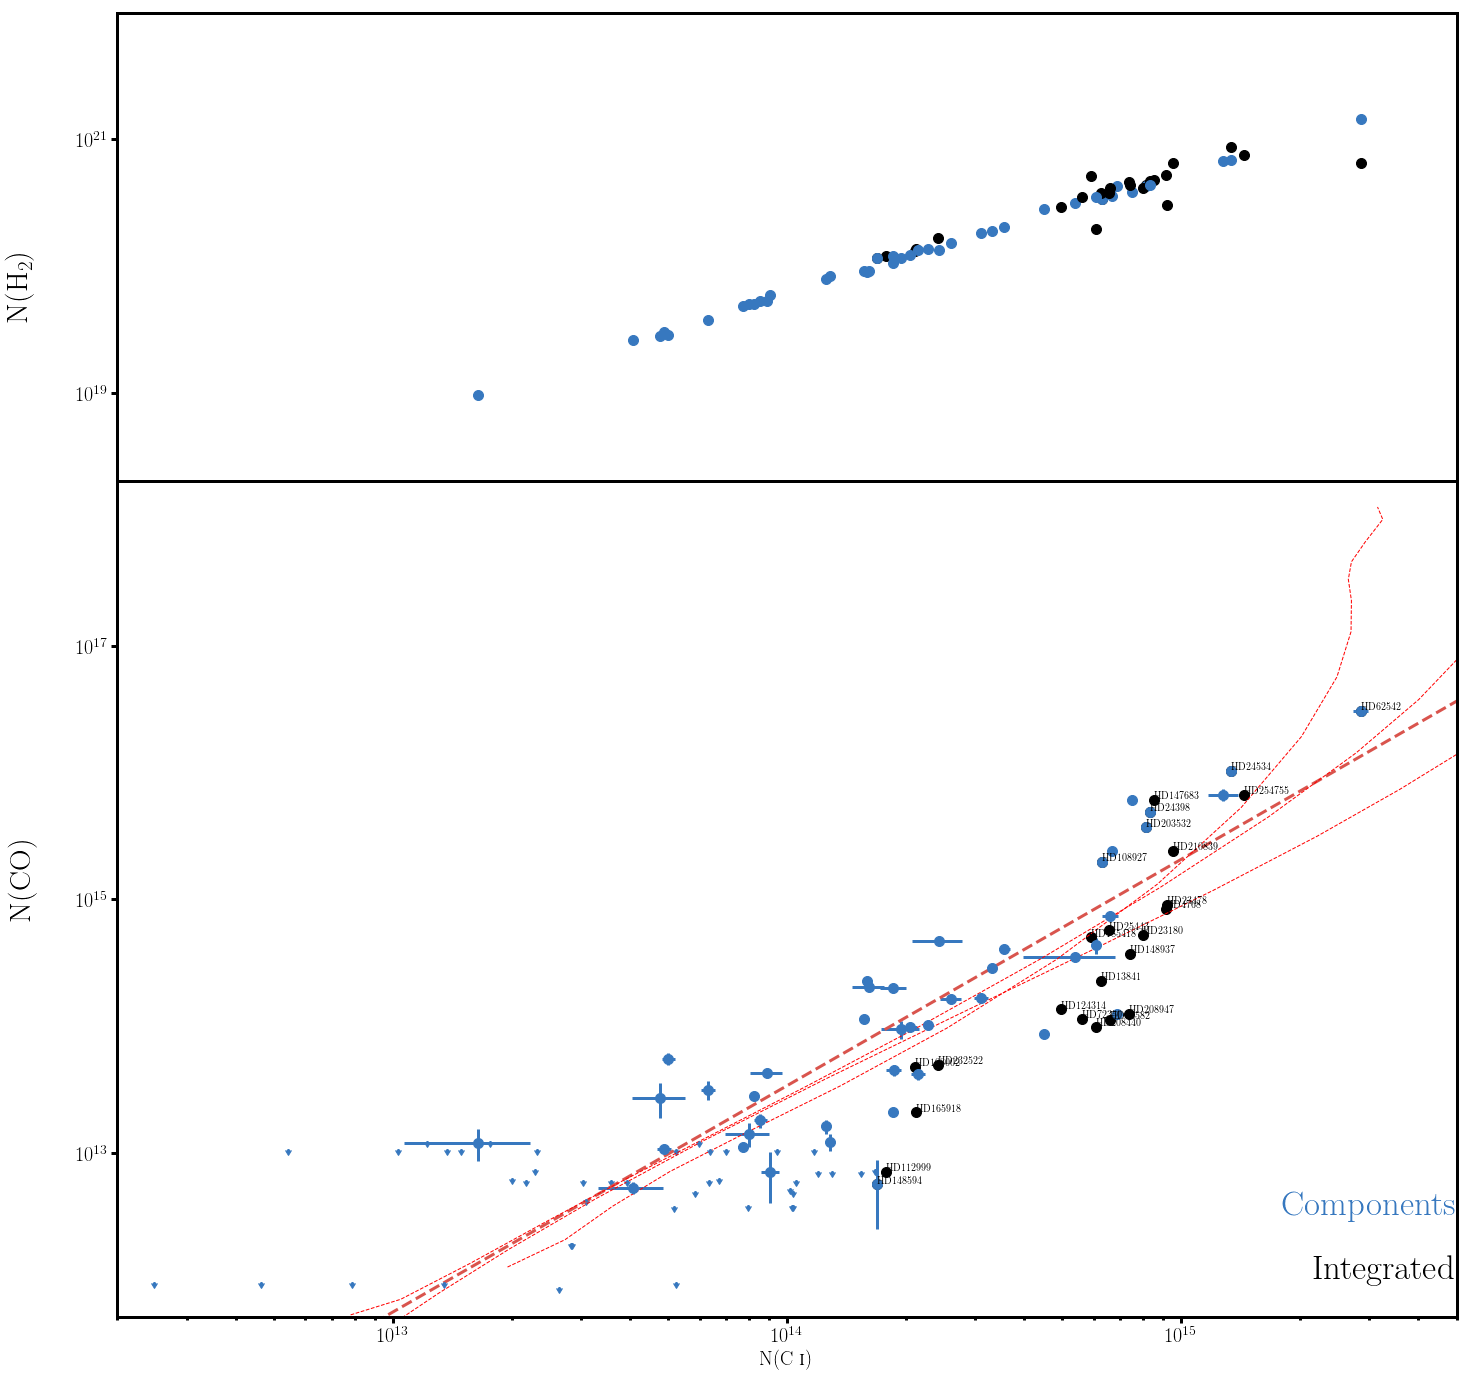

In [5]:
fig=plt.figure(1,figsize=(24,24),facecolor='w')
subplt=plt.subplot(111)

fitx=np.empty(0)
fity=np.empty(0)
for sl,data in all_data.groupby('Sightline'):
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())

    co_sum=np.log10((10**data['CO']).sum())
    
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0:
        h2_sum=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
    subplt.plot(10**c_sum,10**h2_sum,marker='o',color='k',markersize=10)

    subplt.plot(10**c_sum,10**co_sum,marker='o',color='k',markersize=10)
    subplt.text(10**c_sum,10**co_sum,sl)
    
    
    num_c_comps=len(all_data[(all_data['Sightline']==sl)&(all_data['C']>0)])
    for idx,row in data.iterrows():
        c=np.log10((10**row[['C','C*','C**']]).sum())
        c_err=0.434*np.sum([10**row[col+'_err'] for col in ('C','C*','C**')])/10**c
        co=row['CO']
        if co<10:
            subplt.errorbar(10**c,10**row['CO_err'],
                            yerr=0.1*co, uplims=True,color=blue,marker='o',markersize=2)
        else:
            co_h2_ratio=((co-c)-5.4674)/0.949756
            h2=co-co_h2_ratio
            co_err=0.434*(10**(row['CO_err']-co))
            subplt.plot(10**c,10**h2,marker='o',color=blue,markersize=10)
            subplt.errorbar(10**c,10**co,xerr=c_err*(10**c),yerr=co_err*(10**co),marker='o',color=blue,markersize=10)
            fitx=np.concatenate([fitx,[c]])
            fity=np.concatenate([fity,[co]])
        #subplt.text(c, row['CO'], sl+' '+str(row['Velocity']))
        #print '\t',10**(row['CO']-c_tot)
    
fit=linregress(x=fitx,y=fity)
trendx=np.arange(12.5,16,0.1)
y1=fit.slope*trendx+fit.intercept
subplt.plot(10**trendx,10**y1,color=red,linestyle='--',lw=3)
    
#tx=np.arange(12.7,15.8,0.1)
#for rat in (0.01,0.1,1,10):
#    ty=np.array([np.log10(rat*(10**x)) for x in tx])
#    subplt.plot(10**tx,10**ty,'k--')
#    subplt.text(10**tx[-1],10**(ty[-1]-0.04),str(rat),fontsize=25,ha='right',va='bottom',rotation=23)

for n,[(s1,(s1x,s1y)),(s2,(s2x,s2y)),(s3,(s3x,s3y)),(s4,(s4x,s4y))] in theor_results[0:3]:
    # Plot the theoretical results of Gong et al. 2017
    # but with C I values reduced by 1.8 dex
    c=s1y-1.8
    co=s2y
    h2=s4y
    subplt.plot(10**c,10**co,'r--',linewidth=1)
    #subplt.plot(10**c,10**h2,'r--',linewidth=1)
    #subplt.text(s1y[-1]-1.8,s2y[-1],str(n),fontsize=25,ha='center',va='bottom')

subplt.axhline(2e18,linestyle='-')
subplt.set_xlim(2e12,5e15)
subplt.set_ylim(5e11,1e22)
subplt.set_yscale('log')
subplt.set_xscale('log')
subplt.text(-0.06,0.8,'N(H$_2$)',transform=subplt.transAxes,rotation=90,fontsize=30,ha='right')
subplt.text(-0.06,0.35,'N(CO)',transform=subplt.transAxes,rotation=90,fontsize=30,ha='right')
subplt.set_xlabel(' N(C \\textsc{i})',fontsize=20)
subplt.tick_params(axis='both', which='major', labelsize=20)

subplt.text(5e15,10**12.5,'Components',color=blue,fontsize=35,horizontalalignment='right')
subplt.text(5e15,10**12,'Integrated',color='k',fontsize=35,horizontalalignment='right')

#plt.savefig('/Users/codydirks/Desktop/components_vs_integrated.pdf')

Text(4.5e+15,8e+11,'\\textbf{Mine}')

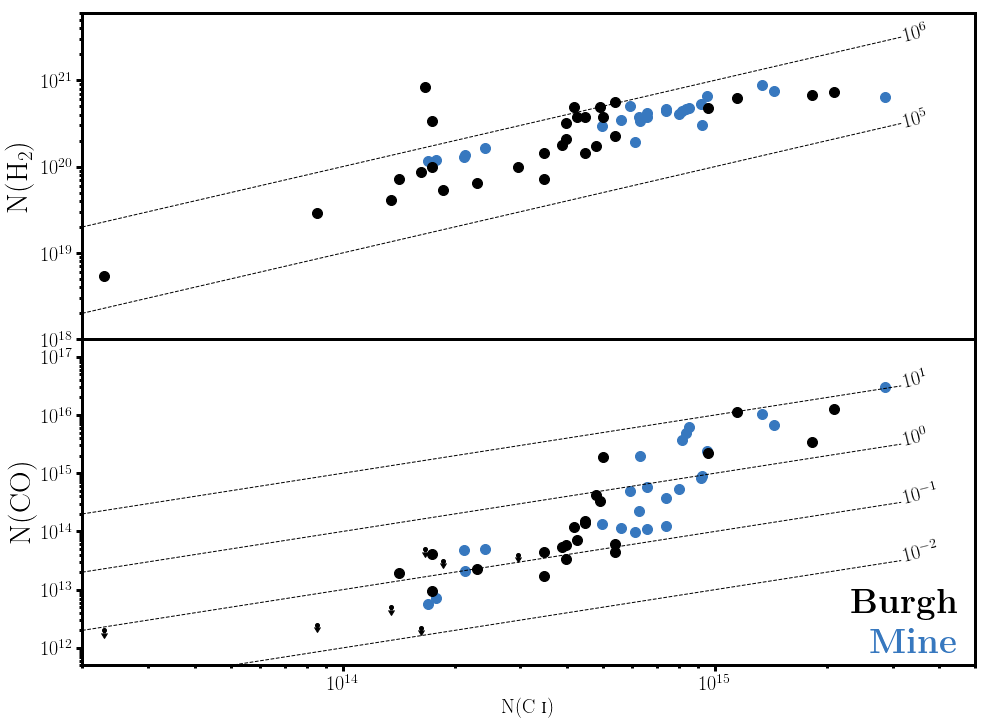

In [6]:
fig=plt.figure(1,figsize=(16,12),facecolor='w')
subplt1=plt.subplot(211)
subplt2=plt.subplot(212)
plt.subplots_adjust(hspace=0)


for sl,data in all_data.groupby('Sightline'):
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())

    co_sum=np.log10((10**data['CO']).sum())
    
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0:
        h2_sum=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
    subplt1.plot(10**c_sum,10**h2_sum,marker='o',color=blue,markersize=10)

    subplt2.plot(10**c_sum,10**co_sum,marker='o',color=blue,markersize=10)
    #subplt2.text(10**c_sum,10**co_sum,sl)



for idx,row in burgh_data.iterrows():
    if row['Sightline'] not in all_data['Sightline'].unique():
    # TODO: Add in upper limits
        cI=float(row['CI'])
        h2=float(row['H2'])
        subplt1.plot(10**cI,10**h2,marker='o',color='k',markersize=10)
        if row['CO'].startswith('<'):
            co=float(row['CO'][1:])
            subplt2.errorbar(10**cI,10**co,yerr=0.1*(10**co), uplims=True,color='k',marker='o',markersize=4)
        else:
            co=float(row['CO'])
            subplt2.plot(10**cI,10**co,marker='o',color='k',markersize=10)

    
tx=np.linspace(10**13.3,10**15.5,10)
for rat in (1e5,1e6):
    ty=rat*tx
    subplt1.plot(tx,ty,'k--',linewidth=1)
    subplt1.text(tx[-1],0.8*ty[-1],'10$^{'+str(int(np.log10(rat)))+'}$',
                fontsize=20,ha='left',va='bottom',rotation=14)
for rat in (0.01,0.1,1,10):#,1e5,1e6):
    ty=rat*tx
    subplt2.plot(tx,ty,'k--',linewidth=1)
    subplt2.text(tx[-1],0.8*ty[-1],'10$^{'+str(int(np.log10(rat)))+'}$',
                fontsize=20,ha='left',va='bottom',rotation=14)

for n,[(s1,(s1x,s1y)),(s2,(s2x,s2y)),(s3,(s3x,s3y)),(s4,(s4x,s4y))] in theor_results:
    pass#subplt.plot(s1y-1.8,s2y,'r--')
    #subplt.text(s1y[-1]-1.8,s2y[-1],str(n),fontsize=25,ha='center',va='bottom')
    
for subplt in (subplt1,subplt2):
    subplt.set_xlim(2e13,5e15)
    subplt.set_yscale('log')
    subplt.set_xscale('log')
    subplt.tick_params(axis='both', which='major', labelsize=20)
    
subplt1.set_ylim(1e18,6e21)
subplt2.set_ylim(5e11,2e17)

subplt2.set_xlabel('N(C \\textsc{i})',fontsize=20)
subplt2.set_ylabel('N(CO)',fontsize=30)
subplt1.set_ylabel('N(H$_2$)',fontsize=30)

subplt2.text(4.5e15,4e12,'\\textbf{Burgh}',color='k',fontsize=35,ha='right')
subplt2.text(4.5e15,0.8e12,'\\textbf{Mine}',color=blue,fontsize=35,ha='right')


#plt.savefig('/Users/codydirks/Desktop/burgh_vs_mine.pdf')

Text(0.5,0,'Molecular Fraction')

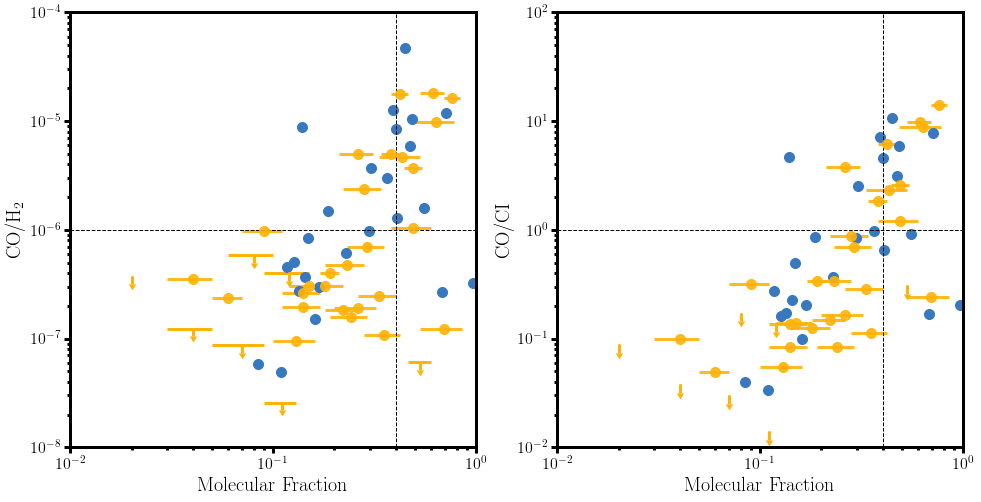

In [7]:
fig,(subplt1,subplt2)=plt.subplots(ncols=2,sharex=True,figsize=(16,8),facecolor='w')


for sl,data in all_data.groupby('Sightline'):
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())
    co_sum=np.log10((10**data['CO']).sum())
    
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    if len(published_h2s)>0:
        h2_sum=np.log10(published_h2s.iloc[-1])
    else:
        co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
        h2_sum=co_sum-co_h2_ratio
    h_sum=np.log10((10**data['H_tot']).sum())
    h1_sum=np.log10(10**(h_sum)-2*10**(h2_sum))
    f=2*10**(h2_sum)/(10**h_sum)
    subplt1.plot(f,10**(co_sum-h2_sum),marker='o',color=blue,markersize=10)
    subplt2.plot(f,10**(co_sum-c_sum),marker='o',color=blue,markersize=10)

for idx,row in burgh_data.iterrows():
    h2=float(row['H2'])
    c=float(row['CI'])
    f=float(row['f'])
    if row['CO'].startswith('<'):
        co=float(row['CO'][1:])
        subplt1.errorbar(f,10**(co-h2),yerr=0.15*(10**(co-h2)),xerr=row['f_err'],
                        uplims=True,color=amber,marker='o',markersize=2)
        subplt2.errorbar(f,10**(co-c),yerr=0.15*(10**(co-c)),
                        uplims=True,color=amber,marker='o',markersize=2)
    else:
        co=float(row['CO'])
        subplt1.errorbar(f,10**(co-h2),xerr=row['f_err'],marker='o',color=amber,markersize=10,alpha=0.9)
        subplt2.errorbar(f,10**(co-c),xerr=row['f_err'],marker='o',color=amber,markersize=10,alpha=0.9)

        
subplt1.axvline(0.4,linestyle='--',lw=1)
subplt2.axvline(0.4,linestyle='--',lw=1)
subplt1.axhline(1e-6,linestyle='--',lw=1)
subplt2.axhline(1,linestyle='--',lw=1)
subplt1.set_yscale('log')
subplt2.set_yscale('log')
subplt1.set_xscale('log')
subplt2.set_xscale('log')
subplt1.set_xlim(0.01,1)
subplt1.set_ylim(1e-8,1e-4)
subplt2.set_ylim(0.01,100)
subplt1.set_ylabel('CO/H$_2$')
subplt2.set_ylabel('CO/CI')
subplt1.set_xlabel('Molecular Fraction')
subplt2.set_xlabel('Molecular Fraction')

Text(0.96,0.03,'\\textbf{Mine}')

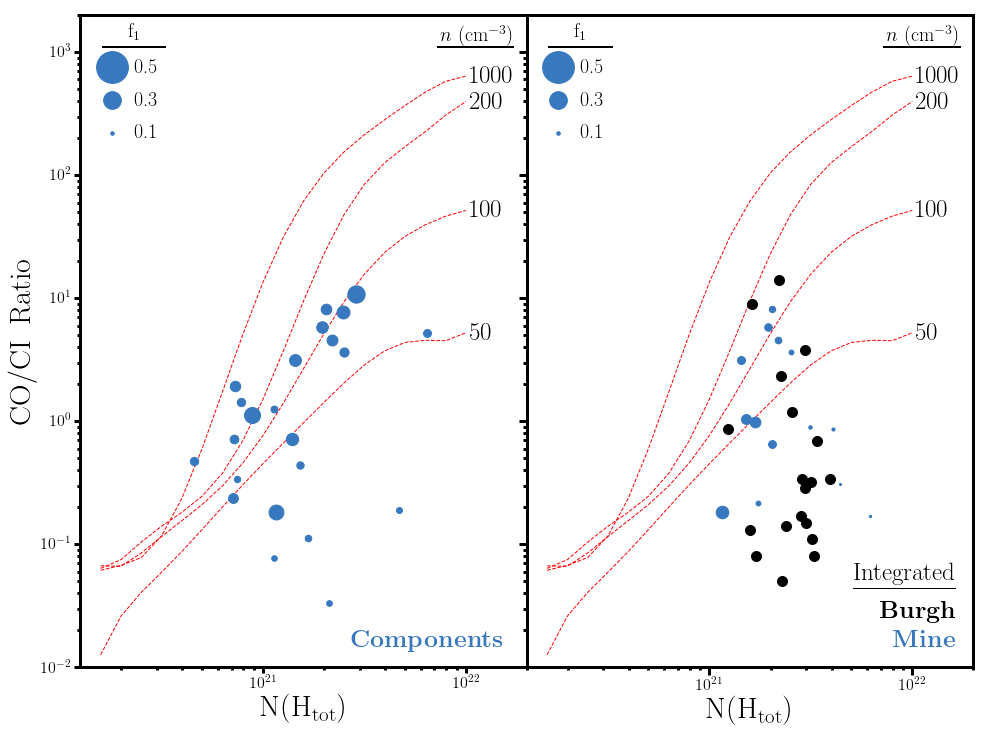

In [8]:
fig=plt.figure(1,figsize=(16,12),facecolor='w')
subplt1=plt.subplot(121)
subplt2=plt.subplot(122)

cut_data=all_data[(all_data['C']>0) & (all_data['CO']>0)&(all_data['O']>16)]

for sl,data in cut_data.groupby('Sightline'):
    # Calculate values for strongest component along this sightline
    row=data.sort_values('CO',ascending=False).iloc[0]
    co=row['CO']
    c=np.log10((10**row[['C','C*','C**']]).sum())
    h2=co-(((co-c)-5.4674)/0.949756)
    f_h2=2*(10**(h2-row['H_tot']))
    
    #Calculate sightline totals for integrated subplot
    c_tot=np.log10(np.sum(10**data[['C','C*','C**']].values))
    co_tot=np.log10(np.sum(10**data['CO']))
    #h2_tot=np.log10(np.sum(10**data['H_2']))
    co_h2_ratio=((co_tot-c_tot)-5.4674)/0.949756
    h2_tot=co_tot-co_h2_ratio
    h_tot=np.log10(np.sum(10**data['H_tot']))
    f_h2_tot=2*(10**(h2_tot-h_tot))
    
    x=10**row['H_tot']
    y=10**(row['CO'])/np.sum(10**(row[['C','C*','C**']].values))
    subplt1.scatter(x,y,marker='o',color=blue,
                    s=300*f_h2,zorder=1)
    if 14.5 < c_tot < 15.:
        subplt2.plot(10**h_tot,10**(co_tot-c_tot),marker='o',color=blue,markersize=17*f_h2_tot,zorder=2)
    
for idx,row in burgh_data.iterrows():
    x=np.log10(10**float(row['HI'])+2*10**float(row['H2']))
    if row['CO/CI'].startswith('<'):
        uplims=True
        y=float(row['CO/CI'][1:])
        yerr=0.1*y
        size=1
    else:
        y=float(row['CO/CI'])
        yerr=0#float(row['Err'])
        uplims=False
        size=10
    if 14.5<float(row['CI'])<15.:
        subplt2.errorbar(10**x,y,yerr=yerr, uplims=uplims,color='k',marker='o',markersize=size,zorder=-1)
    
subplt1.set_ylabel('CO/CI$\;\;$Ratio',fontsize=30)
for subplt in (subplt1,subplt2):
    subplt.set_xlabel('N(H$_{\mathrm{tot}}$)',fontsize=30)
    subplt.set_yscale('log')
    subplt.set_xscale('log')
    subplt.set_ylim(0.01,2000)
    subplt.set_xlim(10**20.1,10**22.3)
    subplt.text(0.97,0.96,'$n$ (cm$^{-3}$)',fontsize=20,transform=subplt.transAxes,ha='right')
    subplt.axhline(1100,0.8,0.97,linewidth=2)
    
    subplt.text(0.12,0.96,'f$_1$',fontsize=20,transform=subplt.transAxes,ha='center')
    subplt.axhline(1100,0.05,0.19,linewidth=2)
    for i,f1 in enumerate([0.1,0.3,0.5]):
        subplt.plot(0.07,0.82+0.05*i,transform=subplt.transAxes,marker='o',color=blue,markersize=np.sqrt(5000.)*(f1-0.05))
        subplt.text(0.12,0.82+0.05*i,str(f1),transform=subplt.transAxes,fontsize=20,va='center')

plt.subplots_adjust(wspace=0)
subplt2.set_yticklabels([])
subplt2.tick_params('y',which='major',length=8)
subplt2.tick_params('x',which='major',length=8)
subplt2.tick_params('y',which='minor',length=4)


for n,[(s1,(s1x,s1y)),(s2,(s2x,s2y)),(s3,(s3x,s3y)),(s4,(s4x,s4y))] in theor_results:
    for subplt in (subplt1,subplt2):
        subplt.plot(10**s1x,10**(s2y-(s1y-1.8)),'r--',zorder=-1,linewidth=1)
        subplt.text(10**(s1x[-1]+0.02),10**(s2y[-1]-(s1y[-1]-1.8)),str(n),fontsize=25,ha='left',va='center')

        
subplt1.text(0.95,0.03,'\\textbf{Components}',fontsize=25,transform=subplt1.transAxes,ha='right',color=blue)

subplt2.text(0.96,0.12,'\\underline{Integrated}',fontsize=25,transform=subplt2.transAxes,ha='right')
subplt2.text(0.96,0.075,'\\textbf{Burgh}',fontsize=25,transform=subplt2.transAxes,ha='right')
subplt2.text(0.96,0.03,'\\textbf{Mine}',fontsize=25,transform=subplt2.transAxes,ha='right',color=blue)


#plt.savefig('/Users/codydirks/Desktop/plots/co_c_ratio_vs_h.pdf')

Text(0.97,0.1,'\\textbf{Components}')

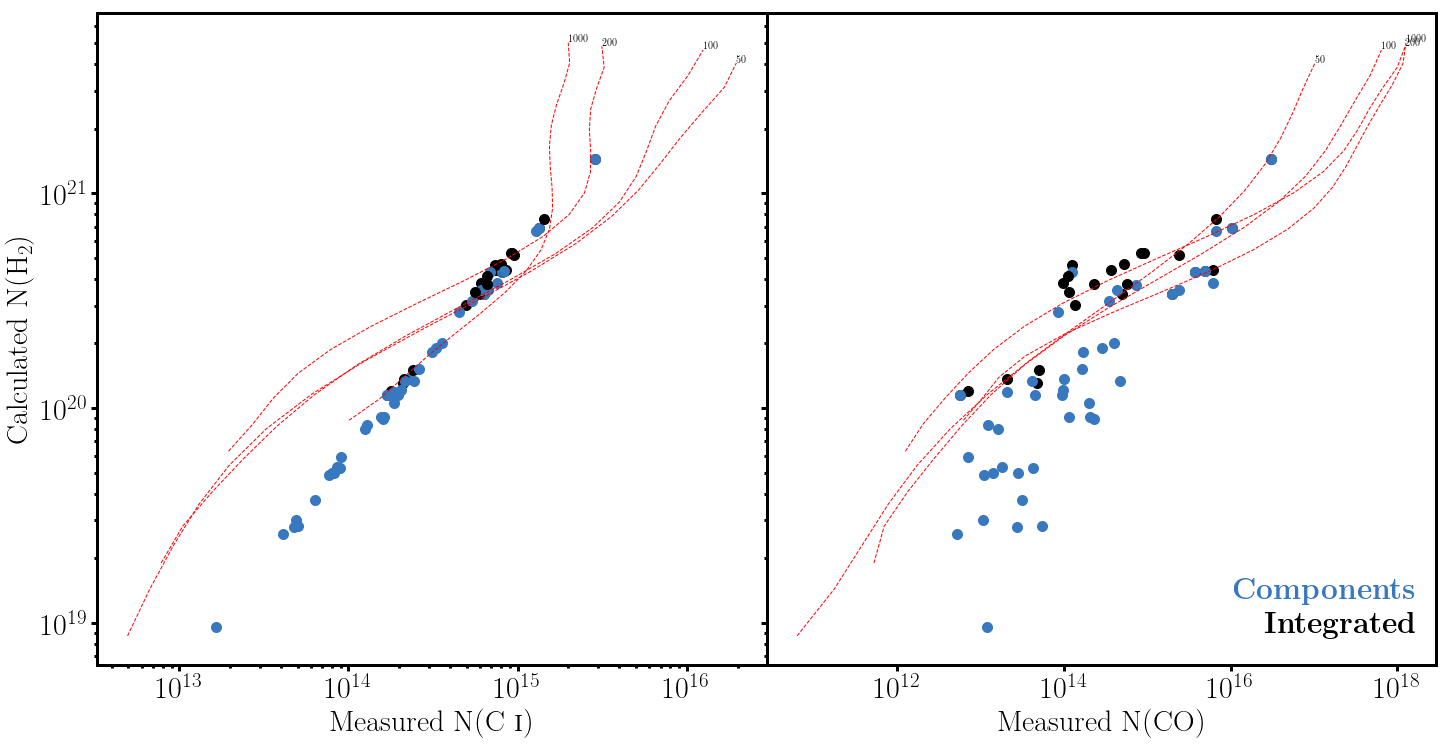

In [9]:
fig=plt.figure(1,figsize=(24,12),facecolor='w')
subplt1=plt.subplot(121)
subplt2=plt.subplot(122)
plt.subplots_adjust(wspace=0)
for sl,data in all_data.groupby('Sightline'):
    c_sum=np.log10((10**data[['C','C*','C**']]).sum().sum())

    co_sum=np.log10((10**data['CO']).sum())
    
    published_h2s=published_hs[published_hs['Name']==sl]['N(H2)']
    #if len(published_h2s)>0:
    #    h2_sum=np.log10(published_h2s.iloc[-1])
    #    subplt1.plot(10**c_sum,10**h2_sum,marker='o',color=amber,markersize=10) 
    #    subplt2.plot(10**co_sum,10**h2_sum,marker='o',color=amber,markersize=10)
    #else:
    co_h2_ratio=((co_sum-c_sum)-5.4674)/0.949756
    h2_sum=co_sum-co_h2_ratio
    if len(data[data['C']>0]):#==len(data[data['CO']>0]):
        subplt1.plot(10**c_sum,10**h2_sum,marker='o',color='k',markersize=10) 
        subplt2.plot(10**co_sum,10**h2_sum,marker='o',color='k',markersize=10)

    
    for idx,row in data[(data['CO']>0)].iterrows():
        c=np.log10((10**row[['C','C*','C**']]).sum())
        c_err=0.434*np.sum([10**row[col+'_err'] for col in ('C','C*','C**')])/10**c
        co=row['CO']
        co_h2_ratio=((co-c)-5.4674)/0.949756
        h2=co-co_h2_ratio
        subplt1.plot(10**c,10**h2,marker='o',color=blue,markersize=10)
        subplt2.plot(10**co,10**h2,marker='o',color=blue,markersize=10)
        
        
for n,[(s1,(s1x,s1y)),(s2,(s2x,s2y)),(s3,(s3x,s3y)),(s4,(s4x,s4y))] in theor_results:
    htot=s1x
    c=s1y-1.8
    co=s2y
    cii=s3y
    h2=s4y
    subplt1.plot(10**c,10**h2,'r--',linewidth=1)
    subplt2.plot(10**co,10**h2,'r--',linewidth=1)
    subplt1.text(10**c[-1],10**h2[-1],n)
    subplt2.text(10**co[-1],10**h2[-1],n)
    
    
subplt1.set_xscale('log')
subplt1.set_yscale('log')
subplt2.set_xscale('log')
subplt2.set_yscale('log')
tx=np.linspace(10**13.3,10**15.5,10)
rat=10**5.4764
ty=rat*tx
#subplt1.plot(tx,ty,'k--',linewidth=1)
#subplt1.text(tx[-1],0.8*ty[-1],'10$^{'+str(int(np.log10(rat)))+'}$',fontsize=20,ha='left',va='bottom',rotation=14)

subplt1.set_ylabel('Calculated N(H$_2$)',fontsize=30)
subplt1.set_xlabel('Measured N(C \\textsc{i})',fontsize=30)
subplt2.set_xlabel('Measured N(CO)',fontsize=30)
subplt2.set_yticklabels([])
subplt1.tick_params(axis='both',labelsize=30)
subplt2.tick_params(axis='both',labelsize=30)
#subplt2.text(0.97,0.02,'\\textbf{Integrated (Published)}',color=amber,fontsize=20,transform=subplt2.transAxes,ha='right')
subplt2.text(0.97,0.05,'\\textbf{Integrated}',color='k',fontsize=30,transform=subplt2.transAxes,ha='right')
subplt2.text(0.97,0.10,'\\textbf{Components}',color=blue,fontsize=30,transform=subplt2.transAxes,ha='right')

#plt.savefig('/Users/codydirks/Desktop/plots/calculated_h2_comparisons.pdf')

0.572166756503


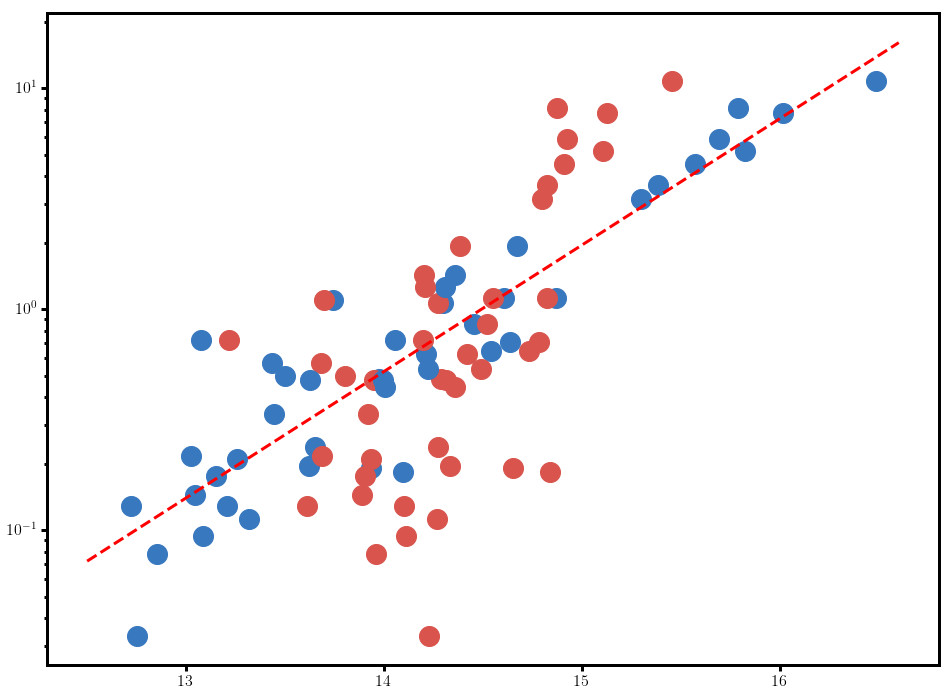

In [39]:
fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)
fitx=[]
fity=[]
for idx,row in all_data[(all_data['CO']>0)].iterrows():
    co=row['CO']
    c=np.log10((10**row[['C','C*','C**']]).sum())
    subplt.plot(co,10**(co-c),marker='o',color=blue,markersize=20)
    subplt.plot(c,10**(co-c),marker='o',color=red,markersize=20)
    fitx.append(co)
    fity.append((co-c))
    
subplt.set_yscale('log')
fitx=np.array(fitx)
fity=np.array(fity)
fit=linregress(x=fitx,y=fity)
trendx=np.arange(12.5,16.7,0.1)
y1=fit.slope*trendx+fit.intercept
subplt.plot(trendx,10**y1,color='r',linestyle='--',lw=3)
print(fit.slope)

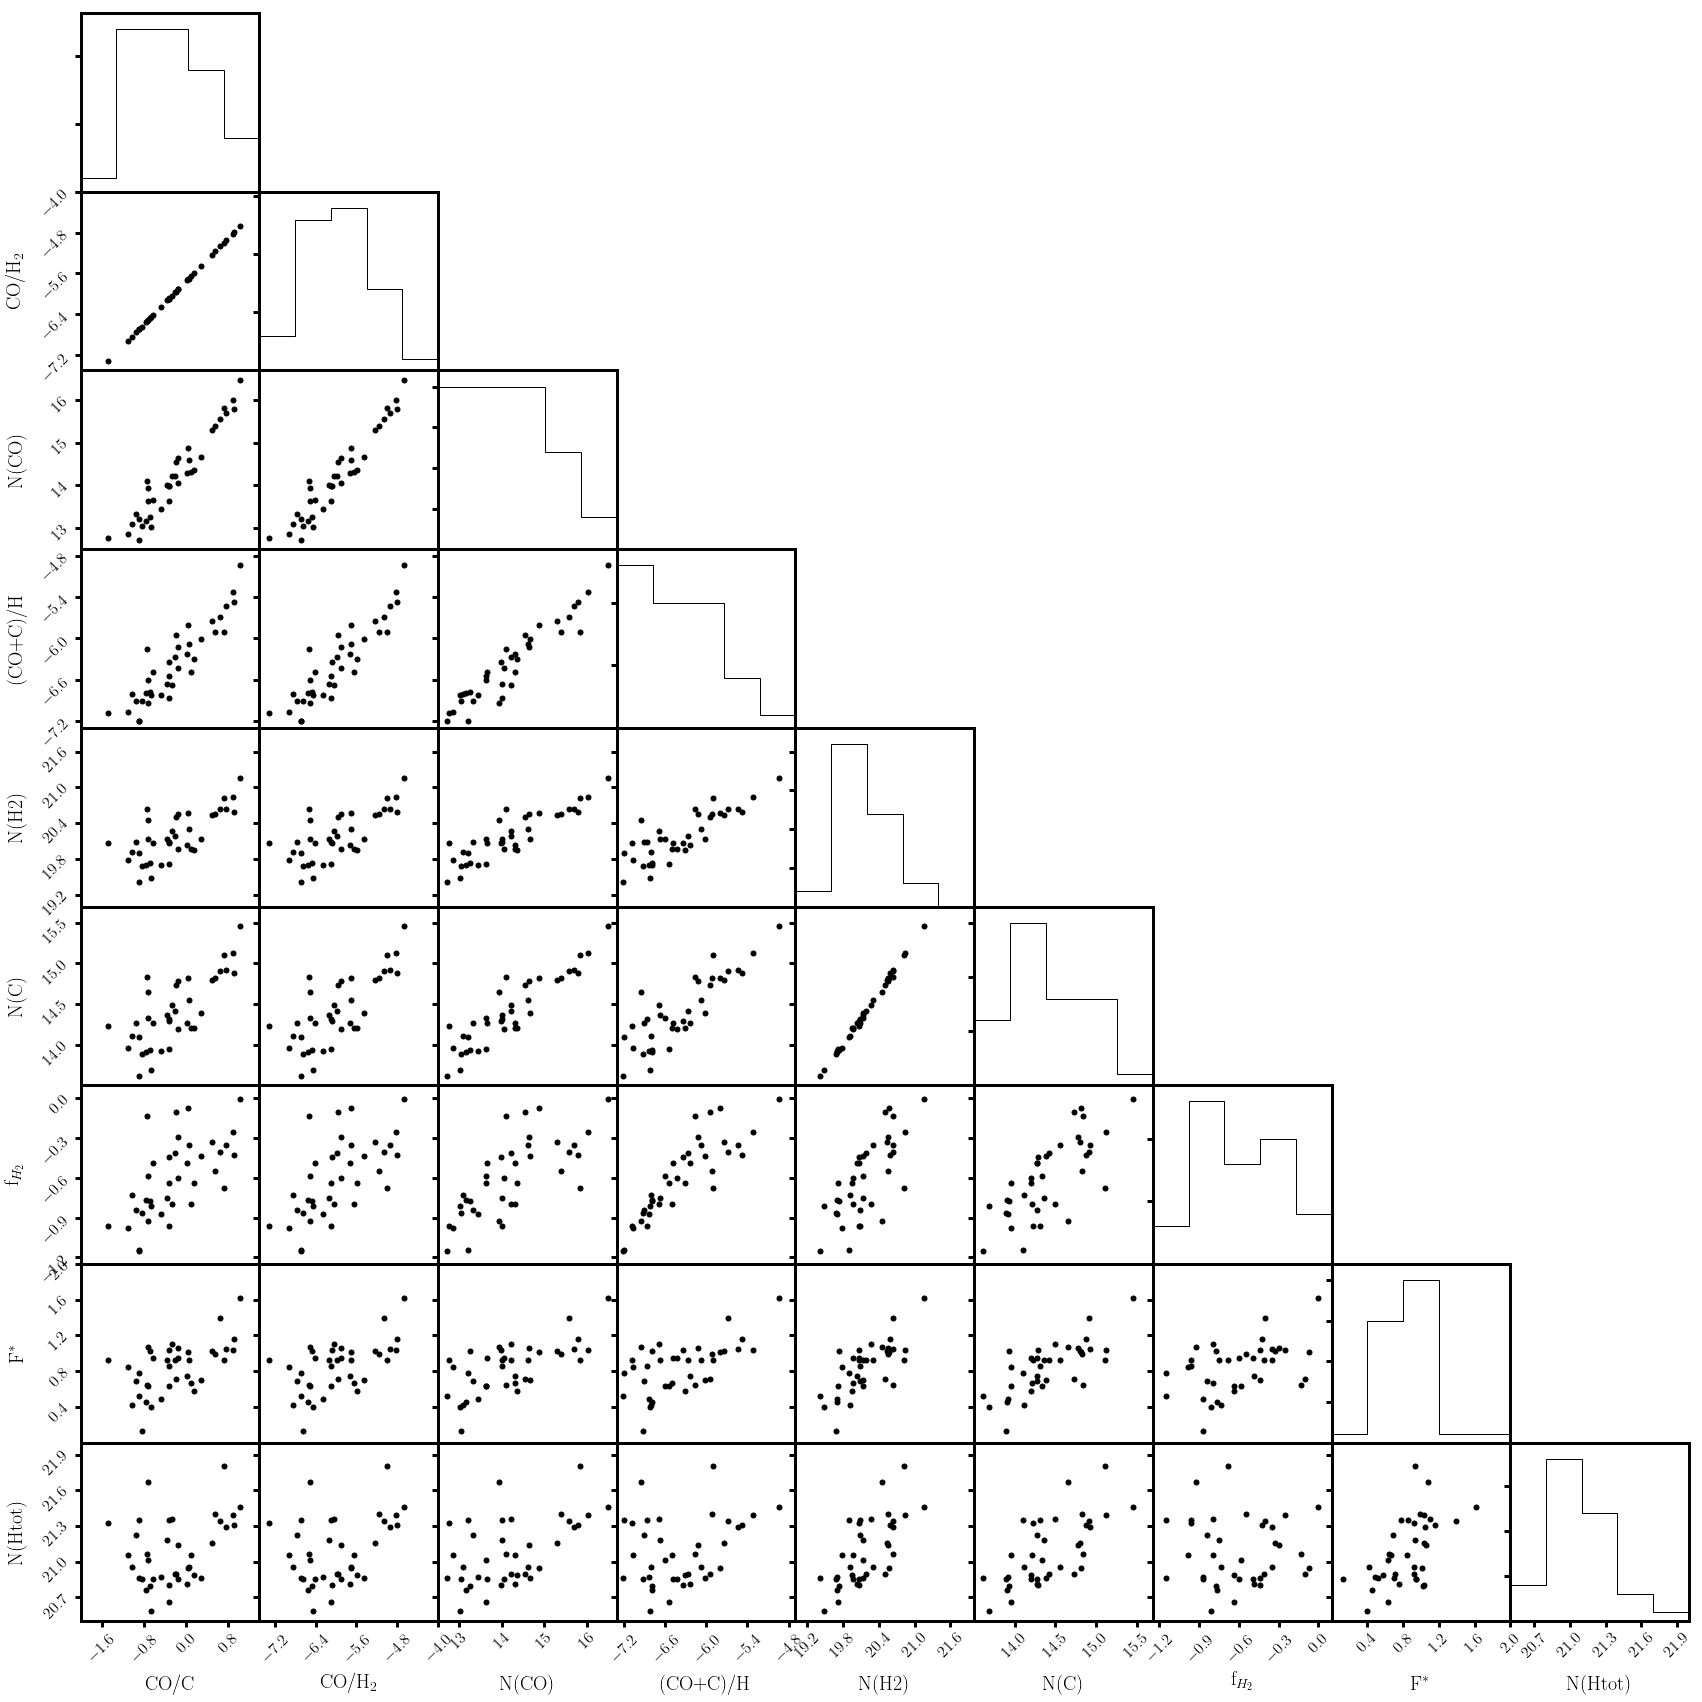

In [11]:
import corner

row_results=[]
for idx,row in all_data[(all_data['CO']>0)&(all_data['CO']>0)&(all_data['H_tot']>19)].iterrows():
    co=row['CO']
    htot=row['H_tot']
    c=np.log10((10**row[['C','C*','C**']]).sum())
    co_h2_ratio=((co-c)-5.4674)/0.949756
    h2=co-co_h2_ratio
    fh2=np.log10(2*(10**h2))-htot
    neut_carb_frac=np.log10((10**(co)+10**(c))/10**htot)
    
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=calc_f(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f=np.mean(f_vals)
    f_err=np.sqrt(np.sum(f_errs**2))
    
    results=(co-c,co_h2_ratio,co,neut_carb_frac,h2,c,fh2,f,htot)
    row_results.append(results)
    
    
data_kwargs=dict()
data_kwargs["color"] ='k'# data_kwargs.get("color", color)
data_kwargs["ms"] = 5#data_kwargs.get("ms", 2.0)
data_kwargs["mec"] = 'k'#data_kwargs.get("mec", "none")
data_kwargs["alpha"] = 1#data_kwargs.get("alpha", 0.1)
figure=corner.corner(row_results,bins=5,plot_datapoints=True,plot_contours=False,plot_density=False,data_kwargs=data_kwargs,
                     labels=('CO/C','CO/H$_2$','N(CO)','(CO+C)/H','N(H2)','N(C)','f$_{H_2}$','F$^*$','N(Htot)'),
                    range=((-2,1.4),(-7.5,-4),(12.5,16.7),(-7.3,-4.7),(19,22),(13.5,15.7),(-1.25,0.1),(0,2),(20.5,22))
                    )

plt.subplots_adjust(wspace=0.0,hspace=0)
figure.set_facecolor('w')
figure.set_figwidth(24)
figure.set_figheight(24)

#plt.savefig('/Users/codydirks/Desktop/corner.pdf')

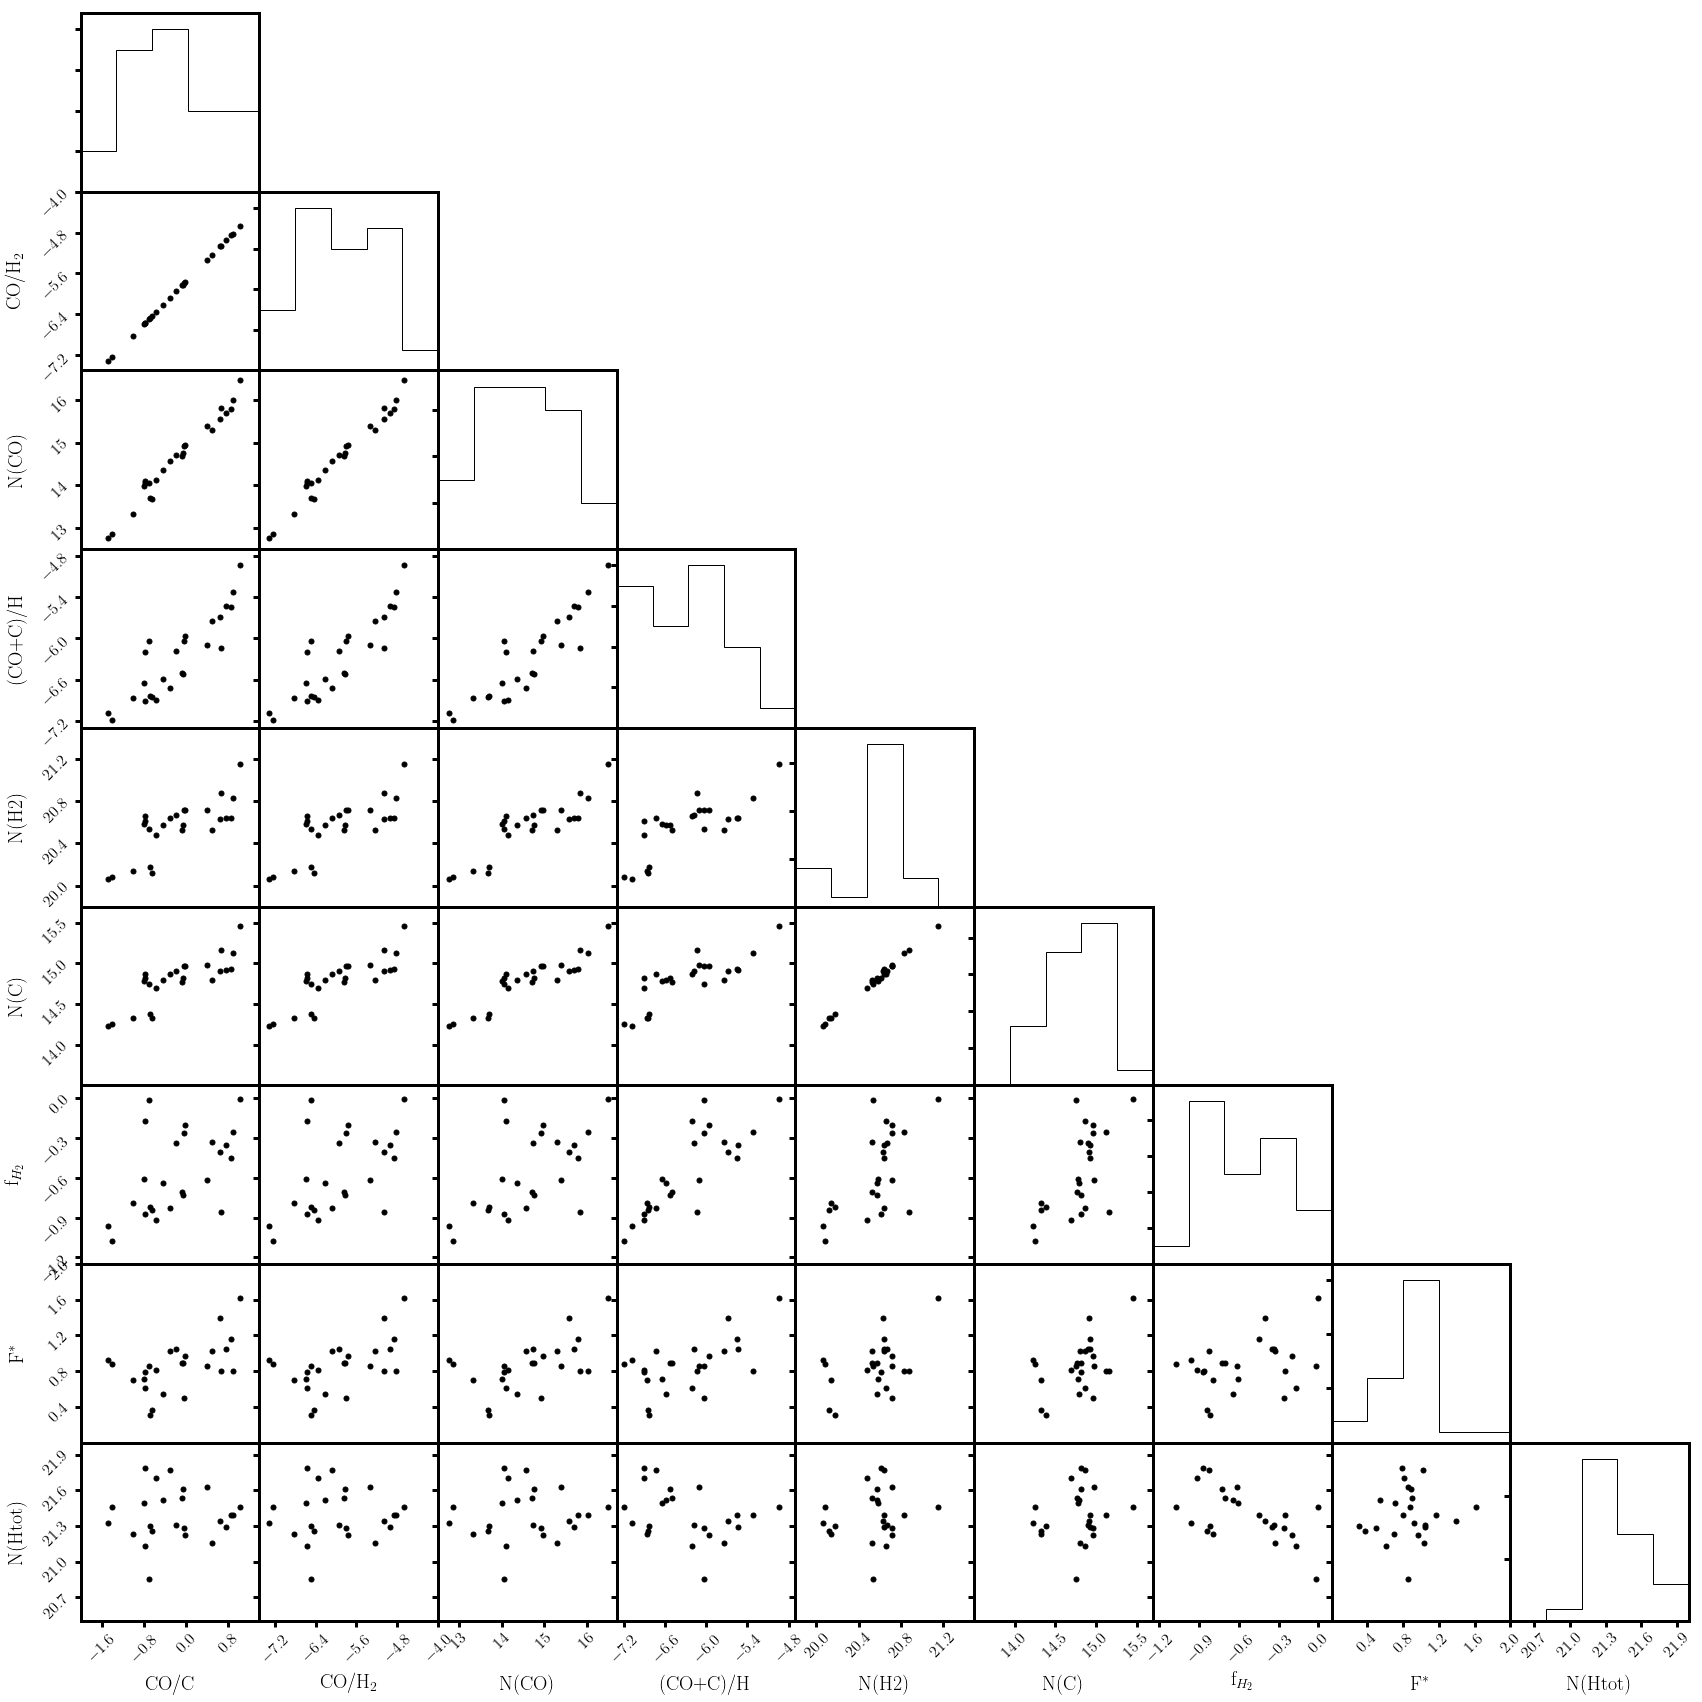

In [12]:
import corner

row_results=[]
for sl,data in all_data.groupby('Sightline'):
    co=np.log10((10**data['CO']).sum())
    htot=np.log10((10**data['H_tot']).sum())
    c=np.log10((10**data[['C','C*','C**']]).sum().sum())
    co_h2_ratio=((co-c)-5.4674)/0.949756
    h2=co-co_h2_ratio
    fh2=np.log10(2*(10**h2))-htot
    neut_carb_frac=np.log10((10**(co)+10**(c))/10**htot)
    
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if data[el2].sum()>0:
            el1sum=np.log10((10**data[el1]).sum())
            el2sum=np.log10((10**data[el2]).sum())
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=calc_f(el1param,el2param,el1sum,el2sum,0,0)
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f=np.mean(f_vals)
    f_err=np.sqrt(np.sum(f_errs**2))
    
    results=(co-c,co_h2_ratio,co,neut_carb_frac,h2,c,fh2,f,htot)
    row_results.append(results)
    
data_kwargs=dict()
data_kwargs["color"] ='k'# data_kwargs.get("color", color)
data_kwargs["ms"] = 5#data_kwargs.get("ms", 2.0)
data_kwargs["mec"] = 'k'#data_kwargs.get("mec", "none")
data_kwargs["alpha"] = 1#data_kwargs.get("alpha", 0.1)
figure=corner.corner(row_results,bins=5,plot_datapoints=True,plot_contours=False,plot_density=False,data_kwargs=data_kwargs,
                     labels=('CO/C','CO/H$_2$','N(CO)','(CO+C)/H','N(H2)','N(C)','f$_{H_2}$','F$^*$','N(Htot)'),
                    range=((-2,1.4),(-7.5,-4),(12.5,16.7),(-7.3,-4.7),(19.8,21.5),(13.5,15.7),(-1.25,0.1),(0,2),(20.5,22)))

plt.subplots_adjust(wspace=0.0,hspace=0)
figure.set_facecolor('w')
figure.set_figwidth(24)
figure.set_figheight(24)

#plt.savefig('/Users/codydirks/Desktop/corner_integrated.pdf')

(40, 410)

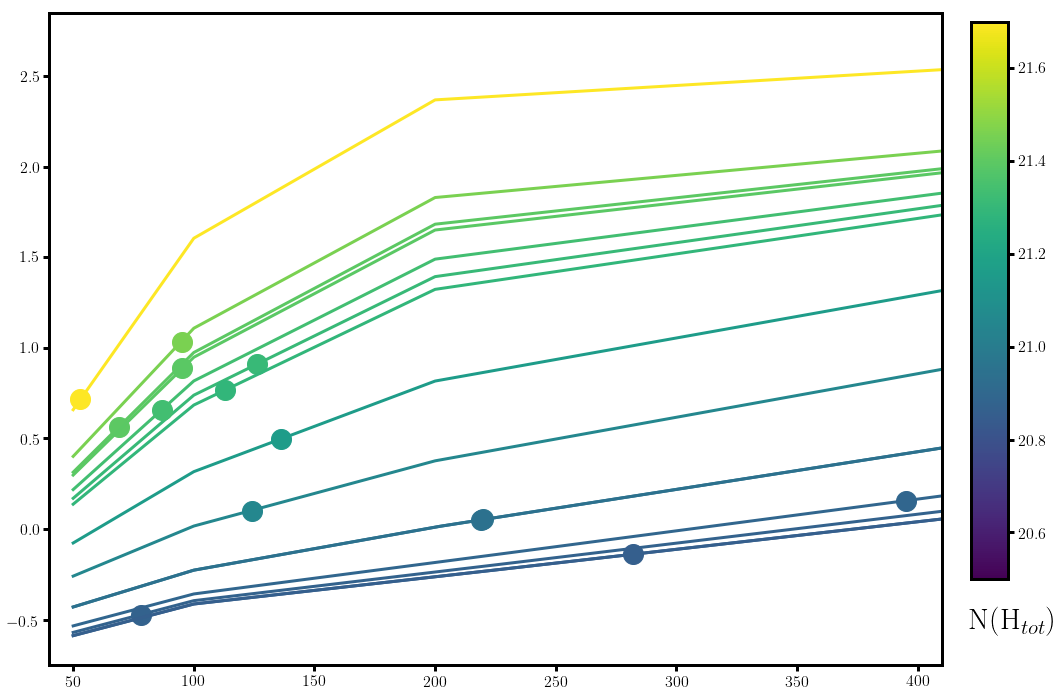

In [236]:
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase,Colorbar
fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)
cmap=plt.cm.viridis
norm=Normalize(vmin=20.5,vmax=21.7)
h_tot=theor_results[0][1][0][1][0]
newx=np.arange(50,1000,1)
for sl,data in list(all_data.groupby('Sightline')):
    row=data.sort_values('CO',ascending=False).iloc[0]
    co=row['CO']
    c=np.log10((10**row[['C','C*','C**']]).sum())
    argmin=np.argmin(abs(row['H_tot']-h_tot))
    x,y=[],[]
    for n,[(s1,(s1x,s1y)),(s2,(s2x,s2y)),(s3,(s3x,s3y)),(s4,(s4x,s4y))] in theor_results:
        # Plot the theoretical results of Gong et al. 2017
        # but with C I values reduced by 1.8 dex
        tc=s1y-1.8
        tco=s2y
        th2=s4y
        th_tot=s1x
        x.append(n)
        y.append(tco[argmin]-tc[argmin])
    fitx=newx[np.argmin(abs(np.interp(newx,x,y)-(co-c)))]
    if fitx>50 and fitx < 999 and row['H_tot']>0:
        col=(cmap(norm(row['H_tot'])))
        subplt.plot(newx,np.interp(newx,x,y),linestyle='-',color=col)
        subplt.plot(fitx,co-c,marker='o',color=col,markersize=20)
    
cax = fig.add_axes([0.925, 0.225, 0.0325, 0.645]) 
ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical',ticks=np.arange(20.4,21.7,0.2))
subplt.text(1.03,0.05,'N(H$_{tot}$)',fontsize=30,transform=subplt.transAxes)
subplt.set_xlim(40,410)

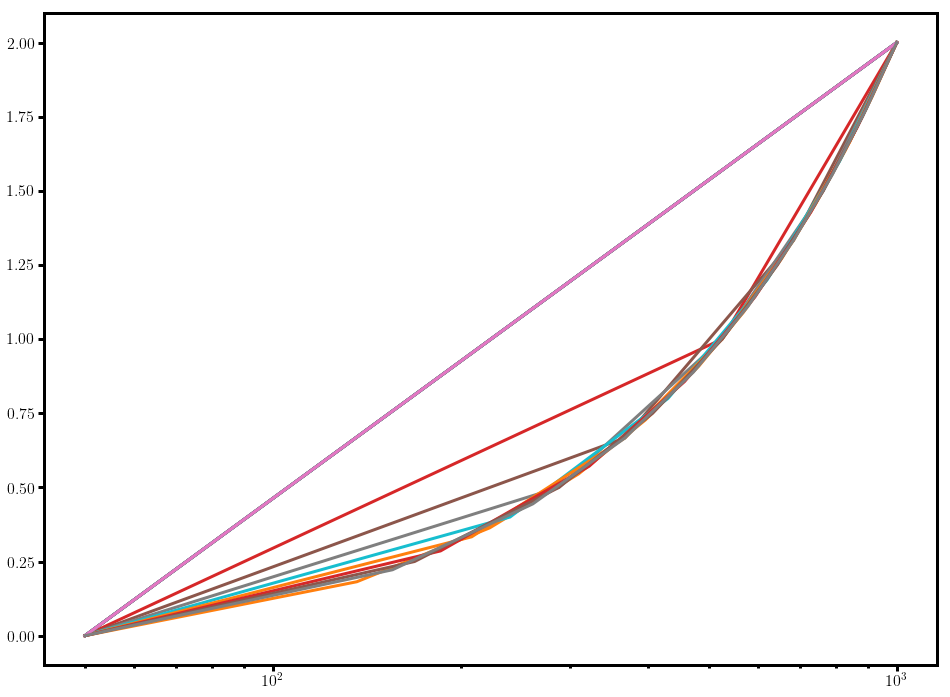

In [239]:
fig=plt.figure(figsize=(16,12),facecolor='w')
subplt=plt.subplot(111)

x=[50,1000]
y=[0,2]
for res in (12,3,4,5,6,7,8,9,10):
    newx=np.linspace(50,1000,res)
    subplt.plot(x,y)
    subplt.plot(newx,np.interp(newx,x,y))
#subplt.set_xlim(50,200)
#subplt.set_ylim(0.25,0.75)
subplt.set_xscale('log')